In [1]:
from model import build_model
from dataset import random_uniform

In [2]:
import tensorflow as tf
import keras
import numpy as np
from sklearn.decomposition import PCA

In [16]:
training_data_cardinality = 2**10
training_data_seed = 4
board_shape = (16, 16)

overcompleteness = 3

batch_size = 16
epochs = 32
n_instances = 12

In [17]:
ds = random_uniform(0.38, (training_data_cardinality, *board_shape), training_data_seed)
ds = ds.batch(batch_size)

In [18]:
class TrajectoryCallback(keras.callbacks.Callback):
    def __init__(self, step_size = 1):
        super().__init__()
        self.step_size = step_size
        self.path = []
        self.losses = []

    def on_epoch_end(self, epoch, logs = None):
        if epoch % self.step_size == 0:
            self.path.append(self.model.get_weights())
            self.losses.append(logs["loss"])

In [19]:
class ConvergenceThreshold(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["loss"]
        if val_acc < self.threshold:
            self.model.stop_training = True

In [20]:
trajectories = []
for i in range(n_instances):
    print(f"Training {i}th instance...")
    optimizer = keras.optimizers.Adam(0.01)
    model = build_model(overcompleteness, i+28, optimizer)
    early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=1, min_delta = 1e-4, verbose=1)
    convergence_threshold = ConvergenceThreshold(0.01)
    trajectory = TrajectoryCallback()
    history = model.fit(
        ds,
        epochs = epochs,
        callbacks = [early_stopping, convergence_threshold, trajectory],
    )
    trajectories.append(trajectory)

Training 0th instance...
Epoch 1/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.7976
Epoch 2/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6457
Epoch 3/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6253
Epoch 4/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6015
Epoch 5/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4577
Epoch 6/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1926
Epoch 7/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0538
Epoch 8/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0165
Epoch 9/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075
Training 1th instance...
Epoch 1/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.9113
Epoch 2/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6523
Epoch 3/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6419
Epoch 4/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6359
Epoch 5/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6268
Epoch 6/32
64/64 ━━━━━━━━━━

In [8]:
def get_weights_shape(weights):
    return [w.shape for w in weights]

def weight_decoder(weights):
    solution = np.array([])
    for i in range(len(weights)):
        solution = np.append(solution, weights[i].flatten())
    return solution

def weight_encoder(solution, weights_shape):
    start = 0
    weights = []
    for i, shape in enumerate(weights_shape):
        finish = np.prod(shape)
        weights.append(np.reshape(solution[start : start + finish], shape))
        start += finish
    return weights

In [155]:
selected_trajectories = sorted(trajectories, key = lambda t: t.losses[-1])
# selected_trajectories = selected_trajectories[:2]
selected_trajectories = np.concatenate((
    selected_trajectories[0:1],
    np.random.choice(selected_trajectories[1:], 5)
))
[(min(trajectory.losses), max(trajectory.losses)) for trajectory in selected_trajectories]

[(0.004172549583017826, 0.7489723563194275),
 (0.008396034128963947, 0.6731486916542053),
 (0.23423989117145538, 1.3352349996566772),
 (0.25908878445625305, 0.7462493181228638),
 (0.006406454835087061, 0.7227052450180054),
 (0.23423989117145538, 1.3352349996566772)]

In [156]:
weights_origin = selected_trajectories[0].path[-1]
weights_shape = get_weights_shape(weights_origin)
params_origin = weight_decoder(weights_origin)

flat_params = [np.array([weight_decoder(weights) for weights in trajectory.path]) for trajectory in selected_trajectories]

trajectory_losses = [trajectory.losses for trajectory in selected_trajectories]

weights_shape, params_origin.shape, len(flat_params)

([(3, 3, 1, 6), (6,), (1, 1, 6, 3), (3,), (1, 1, 3, 1), (1,)], (85,), 6)

In [157]:
diffs = [np.subtract(path_params, params_origin) for path_params in flat_params]
flat_diff = np.vstack(diffs)
print(len(diffs), diffs[0].shape, flat_diff.shape)

pca = PCA(n_components=2)
pca.fit(flat_diff)

shift = pca.transform(diffs[0][-1].reshape((1, -1))).T

points_tr = [pca.transform(diff) for diff in diffs]
inverse_tr = [pca.inverse_transform(points) for points in points_tr]

mse = [np.square(diff - inverse_diff).mean(axis=1) for diff, inverse_diff in zip(diffs, inverse_tr)]
min_mse = np.min([np.min(m) for m in mse])
max_mse = np.max([np.max(m) for m in mse])

reduced = [points.T for points in points_tr]
print(len(reduced), reduced[0].shape)

dir1 = pca.components_[0]
dir2 = pca.components_[1]

6 (9, 85) (123, 85)
6 (2, 9)


In [159]:
pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)


(array([0.59622135, 0.19476735]), 0.7909887008943416)

In [160]:
grid_size = 12
bx, by = 1, 1
minx = np.min([np.min(xs) for xs, ys in reduced]) - bx
maxx = np.max([np.max(xs) for xs, ys in reduced]) + bx
miny = np.min([np.min(ys) for xs, ys in reduced]) - by
maxy = np.max([np.max(ys) for xs, ys in reduced]) + by
alpha = np.linspace(minx - bx, maxx + bx, grid_size)
beta = np.linspace(miny - by, maxy + by, grid_size)

In [161]:
grid_xx, grid_yy = np.meshgrid(alpha, beta)
loss_grid_coords = np.dstack((grid_xx, grid_yy))
loss_grid_samples = loss_grid_coords.reshape((grid_size*grid_size, 2))

inverse_t_grid = pca.inverse_transform(loss_grid_samples)
loss_grid_params = params_origin + inverse_t_grid

loss_grid_flat = np.zeros(shape=grid_size*grid_size)
for i, params in enumerate(loss_grid_params):
    model.set_weights(weight_encoder(params, weights_shape))
    loss = model.evaluate(ds, verbose=0)
    loss_grid_flat[i] = loss


loss_grid = loss_grid_flat.reshape((grid_size, grid_size))
print(loss_grid.shape)
model.set_weights(weights_origin)

(12, 12)


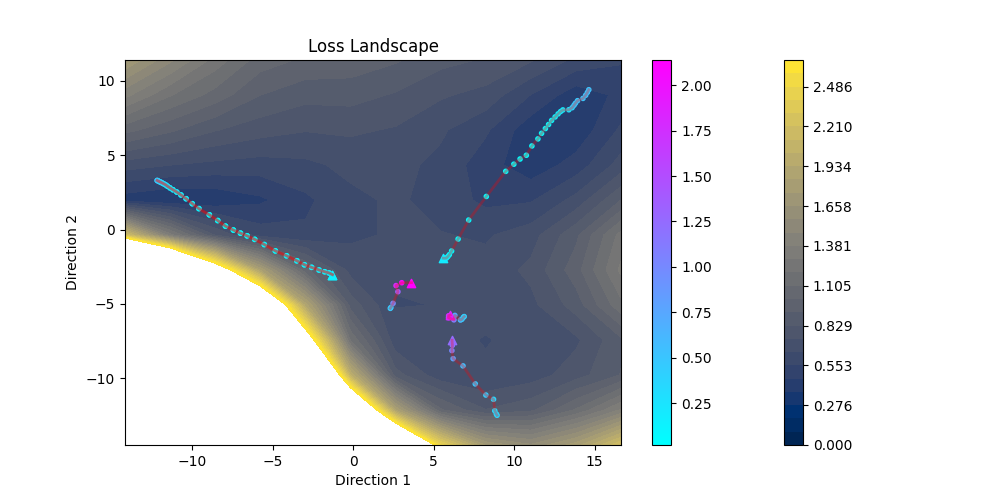

In [164]:
%matplotlib widget
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)


max_trajectory_loss = np.max([np.max(trajectory.losses) for trajectory in selected_trajectories])
levels = np.linspace(0.0, 1.0, 30)**1.0 * max_trajectory_loss * 2.0
contour = ax.contourf(grid_xx, grid_yy, loss_grid, levels=levels, cmap='cividis')
# ax.clabel(contour, inline=True, inline_spacing = 16, fmt="%.2f", fontsize=8, colors='black')
plt.colorbar(contour)

for (xs, ys), zs in zip(reduced, mse):
    zs = zs[::-1]
    scatter = ax.scatter(xs[1:], ys[1:], c=zs[1:], vmin=min_mse, vmax=max_mse, marker=".", cmap="cool")
    ax.scatter(xs[0], ys[0], c=zs[0], vmin=min_mse, vmax=max_mse, marker="^", cmap="cool")
    plot = ax.plot(xs, ys, linewidth=2, color="red", alpha = 0.3)
plt.colorbar(scatter)

plt.title('Loss Landscape')
plt.xlabel('Direction 1')
plt.ylabel('Direction 2')
plt.show()